# Fine-tune BLIP for Car State Components

## Set-up environment

In [5]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-i8fitvvf
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-i8fitvvf
  Resolved https://github.com/huggingface/transformers.git to commit beaed8ce01c2f24e1d520efd96e7091f0f0623e2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer
import os

# --- Configuration ---
CSV_PATH = "/content/drive/MyDrive/ML/datasets/image_to_text_annotations.csv"  # Replace with the actual path to your CSV file
IMAGE_DIR = "/content/datasets" # Replace with the path to the directory containing your images
MODEL_NAME = "Salesforce/blip-image-captioning-base"
OUTPUT_DIR = "/content/blip"
NUM_TRAIN_EPOCHS = 3
PER_DEVICE_TRAIN_BATCH_SIZE = 5 # Adjust based on your GPU memory
PER_DEVICE_EVAL_BATCH_SIZE = 5 # Adjust based on your GPU memory
LEARNING_RATE = 5e-5
RANDOM_SEED = 42

In [7]:
from google.colab import drive


print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully at /content/drive")

zip_file_path_in_drive = "/content/drive/MyDrive/ML/datasets/datasets-full.zip"

extraction_path_in_colab = "/content"

import os

# Check if the ZIP file exists
if not os.path.exists(zip_file_path_in_drive):
  print(f"ERROR: ZIP file not found at '{zip_file_path_in_drive}'. Please check the path and try again.")
else:
  print(f"ZIP file found: '{zip_file_path_in_drive}'")

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_path_in_colab):
  os.makedirs(extraction_path_in_colab)
  print(f"Created extraction directory: '{extraction_path_in_colab}'")
else:
  print(f"Extraction directory already exists: '{extraction_path_in_colab}'")

#@title 3. Extract the ZIP File
import zipfile
import time

# Ensure the paths are set from the previous cell
if not 'zip_file_path_in_drive' in globals() or not os.path.exists(zip_file_path_in_drive):
  print("ERROR: ZIP file path is not correctly set or the file does not exist. Please run Step 2 first.")
elif not 'extraction_path_in_colab' in globals():
  print("ERROR: Extraction path is not correctly set. Please run Step 2 first.")
else:
  try:
    print(f"Starting extraction of '{zip_file_path_in_drive}' to '{extraction_path_in_colab}'...")
    start_time = time.time()

    # Open the ZIP file
    with zipfile.ZipFile(zip_file_path_in_drive, 'r') as zip_ref:
      zip_ref.extractall(extraction_path_in_colab)

    end_time = time.time()
    extraction_time = end_time - start_time
    print(f"Successfully extracted '{zip_file_path_in_drive}' to '{extraction_path_in_colab}'")
    print(f"Extraction took {extraction_time:.2f} seconds.")

  except zipfile.BadZipFile:
    print(f"ERROR: The file '{zip_file_path_in_drive}' is not a valid ZIP file or is corrupted.")
  except FileNotFoundError:
    print(f"ERROR: The ZIP file '{zip_file_path_in_drive}' was not found. Please ensure the path is correct.")
  except Exception as e:
    print(f"An unexpected error occurred during extraction: {e}")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully at /content/drive
ZIP file found: '/content/drive/MyDrive/ML/datasets/datasets-full.zip'
Extraction directory already exists: '/content'
Starting extraction of '/content/drive/MyDrive/ML/datasets/datasets-full.zip' to '/content'...
Successfully extracted '/content/drive/MyDrive/ML/datasets/datasets-full.zip' to '/content'
Extraction took 2.39 seconds.


In [9]:
# --- 1. Load and Split Data ---
try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    print(f"Error: The file {CSV_PATH} was not found. Please check the path.")
    exit()

if 'filename' not in df.columns or 'text' not in df.columns:
    print("Error: CSV must contain 'filename' and 'text' columns.")
    exit()

# Ensure text data is clean (remove extra spaces, newlines)
df['text'] = df['text'].str.replace('\s+', ' ', regex=True).str.strip()

train_df, eval_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

print(f"Training samples: {len(train_df)}")
print(f"Evaluation samples: {len(eval_df)}")

Training samples: 2048
Evaluation samples: 512


## Load model and processor

In [12]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, df, image_dir, processor, max_length=512): # Increased max_length for potentially longer descriptions
        self.df = df
        self.image_dir = image_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row['filename'])
        text = row['text']

        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image file not found {image_path}. Skipping.")
            if idx + 1 < len(self):
                return self.__getitem__(idx + 1)
            else:
                raise FileNotFoundError(f"Critical: Image file not found {image_path} and no more items.")


        encoding = self.processor(images=image, text=text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")

        encoding = {k: v.squeeze() for k, v in encoding.items()}

        encoding["labels"] = encoding["input_ids"].clone()

        return encoding

In [13]:
# --- 3. Initialize Model and Processor ---
processor = AutoProcessor.from_pretrained(MODEL_NAME)
model = BlipForConditionalGeneration.from_pretrained(MODEL_NAME)

# Create datasets
train_dataset = ImageCaptioningDataset(train_df, IMAGE_DIR, processor)
eval_dataset = ImageCaptioningDataset(eval_df, IMAGE_DIR, processor)

## Train the model

In [15]:
# --- 4. Set up TrainingArguments ---
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    remove_unused_columns=False,
    fp16=torch.cuda.is_available(),
    seed=RANDOM_SEED,
    report_to="none"
)

In [16]:
# --- 5. Use the Trainer API ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.007500,0.007171
2,0.007200,0.006974
3,0.006900,0.006931


There were missing keys in the checkpoint model loaded: ['text_decoder.cls.predictions.decoder.bias'].


TrainOutput(global_step=1230, training_loss=0.31045731707074775, metrics={'train_runtime': 1159.9304, 'train_samples_per_second': 5.297, 'train_steps_per_second': 1.06, 'total_flos': 3.6459949192705475e+18, 'train_loss': 0.31045731707074775, 'epoch': 3.0})

## Inference

Let's check the results on our train dataset

filename    view_rear_side_left_front_left_closed_front_ri...
text        The front left door is closed, the front right...
Name: 1737, dtype: object


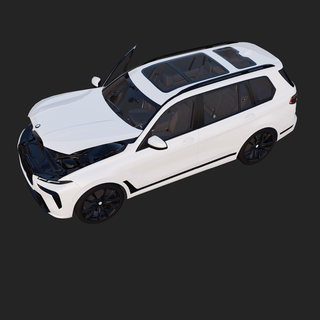

In [38]:
# load eval image
example = eval_df.iloc[1]
print(example)

filename_path = os.path.join(IMAGE_DIR, example["filename"])
image = Image.open(filename_path).convert("RGB")
image

In [42]:
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

the front left door is open, the front right door is closed, the rear left door is closed, the rear right door is closed, and the hood is open.


## Store to Hub


In [40]:
from huggingface_hub import notebook_login

notebook_login()

In [41]:
repo_name = "noczero/blip-finetuned-car-state-components"

model.push_to_hub(repo_name, commit_message="add finetuned model")

processor.push_to_hub(repo_name, commit_message="add finetuned model")

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/noczero/blip-finetuned-car-state-components/commit/0349a0923e8505be4e51f511c2e1c9b430c1b9ad', commit_message='add finetuned model', commit_description='', oid='0349a0923e8505be4e51f511c2e1c9b430c1b9ad', pr_url=None, repo_url=RepoUrl('https://huggingface.co/noczero/blip-finetuned-car-state-components', endpoint='https://huggingface.co', repo_type='model', repo_id='noczero/blip-finetuned-car-state-components'), pr_revision=None, pr_num=None)